# A multi-compartmental model of a pyramidal neuron

 

## Step 1: Setup

In [1]:
# Setup inline plotting
%matplotlib widget
#%matplotlib inline
import matplotlib.pyplot as plt
#import matplotlib
#matplotlib.rcParams['path.simplify'] = False

In [2]:
# For Google Colab, this line installs NEURON
!pip install neuron quantities neurom 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.6/489.6 kB 3.3 MB/s eta 0:00:000:00:01m eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 1.6 MB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for neurom: filename=neurom-3.2.2-py3-none-any.whl size=105772 sha256=c5655c16720a3687e32167f8b6987e82a68c0fa0e9bb6a579a19be0ba93cc9fe
  Stored in directory: /home/emuller/.cache/pip/wheels/81/1c/1b/230faac1c1451ca810f976e48add8ae36b9902365aa9f7cd1f
Successfully built neurom


In [2]:
# We will let this library handle unit conversion for us
import quantities as pq
from quantities import um, nS, mV, cm, ms, nA, S, uF, Hz, degrees, s, MOhm, mS, mm, Ohm, pS

In [4]:
# Import and initialize NEURON
import neuron
from neuron import h
h.load_file("stdrun.hoc")
h.load_file("import3d.hoc")
#h.load_file("stdlib.hoc") # need geom_nseg

1.0

In [5]:
# Import other modules we need
import numpy as np
from tqdm import tqdm
import time

In [7]:
import neurom as nm

In [8]:
from neurom.view import matplotlib_impl, matplotlib_utils

In [9]:
morph = nm.load_morphology('data/morphology.asc')

Text(0, 0.5, 'y ($\\rm{\\mu m}$)')

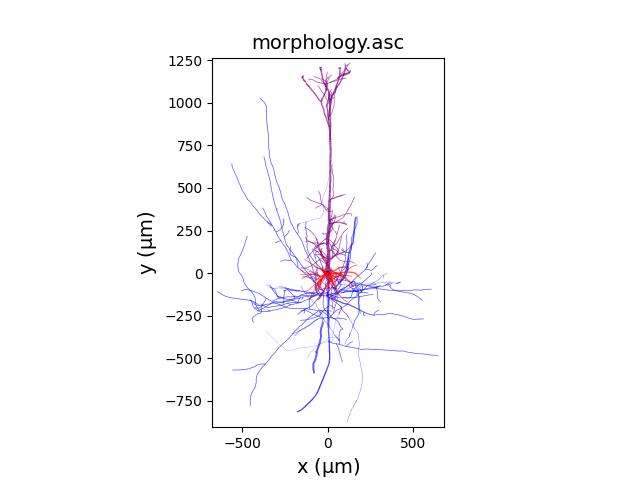

In [10]:
# instead of: viewer.draw(m)
matplotlib_impl.plot_morph(morph)
plt.xlabel(r"x ($\rm{\mu m}$)") 
plt.ylabel(r"y ($\rm{\mu m}$)") 

In [13]:
# instead of: viewer.draw(m, mode='3d')
#matplotlib_impl.plot_morph3d(morph)

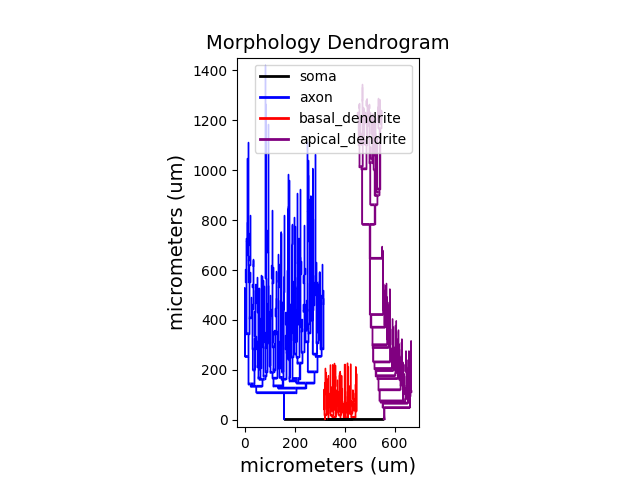

In [14]:
# instead of: viewer.draw(m, mode='dendrogram')
matplotlib_impl.plot_dendrogram(morph)

## Step 2: Define the circuit


In [11]:
# constants
h.dt = 0.025
h.celsius = 34

In [12]:
def rerun_sim(tstop, tskip=0, v_init=-84.0, viz=False, steps=50, framerate=None):
    if framerate:
        dt = 1.0/framerate
    else:
        dt = None
    h.finitialize( float(v_init) )
    h.continuerun( float(tskip * ms) )
    for t in tqdm(np.linspace(tskip,tstop,steps)):
        t1 = time.time()
        h.continuerun( float(t * ms) )
        if viz==True:
            sp.flush()
        t2 = time.time()
        if dt:
            wait = dt-(t2-t1)
            if wait > 0:
                time.sleep(wait)

In [13]:
class MyCell:
    def __init__(self):
        """ Create the neuron, load the morphology, replace the axon with a stub, 
        configure nseg for each compartment
        """
        # This idiom below imports the morphology file and instaniates it as h.Sections
        morph_reader = h.Import3d_Neurolucida3()
        morph_reader.input('data/morphology.asc')
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self)
        
        self.replace_axon()
        self.geom_nseg()
        self.check_diameters()
        
        # Alias for readability 
        self.basal = self.dend
        self.apical = self.apic
        self.axonal = self.axon
        
    def geom_nseg(self):
        """ Setup the nseg parameter for all sections
        Results in about 2 compartments per 40um
        """
        for sec in self.soma[0].wholetree():
            sec.nseg = int((sec.L/(0.1*h.lambda_f(2500))+.9)/2)*2 + 1
            #sec.nseg = int(sec.L/40)*2 + 1
    
    def check_diameters(self):
        """ Check there are no small diameter sections"""
        for sec in self.dend:
            if sec.diam<0.001:
                raise ValueError("diam=%f at section '%s'" % (sec.diam, sec.name()))
        
        for sec in self.apic:
            if sec.diam<0.001:
                raise ValueError("diam=%f at section '%s'" % (sec.diam, sec.name()))                    
    
    def replace_axon(self):
        """ We will not simulate the axon, 
        so this function deletes it and replaces it with a stub with same diameter """
        # Find the axonal section that connects to the soma
        axon_root = [x for x in self.soma[0].children() if x in self.axon]
        # There should be only one for this morphology
        assert len(axon_root)==1
        axon_root = axon_root[0]
        
        # Get diameter
        d = axon_root(0.0).diam
        
        # Delete all axon sections
        for sec in self.axon:
            h.delete_section(sec=sec)
        
        # Create new axon
        axon = h.Section()
        self.axon = [axon]
        axon.L = 60                                                              
        axon.diam = d   
        
        # Connect it to the some
        axon.connect(self.soma[0](1.0),0.0)
        

In [14]:
m = MyCell()


14982 lines read


In [15]:
m

In [16]:
print('%d apic sections' % len(m.apic))
print('%d basal sections' % len(m.dend))
print('%d somatic sections' % len(m.soma))
print('%d axonal sections' % len(m.axon))

150 apic sections
83 basal sections
1 somatic sections
1 axonal sections


In [17]:
# An alias for the soma
soma = m.soma[0]

#### Count the number of sections and segments

In [18]:
num_segments = sum([d.nseg for d in soma.wholetree()])

In [19]:
num_segments

607

In [20]:
num_sections =0
for sec in soma.wholetree():
    num_sections+=1

In [21]:
num_sections  

235

#### Visualize the neuron within NEURON!

In [22]:
# Only works if Jupyter & NEURON are running locally, I imagine.
#from neuron import gui

#sp = h.PlotShape()


In [23]:
#sp.show(1)
#sp.show(0)  # show diameters

### Query NEURON for soma.L, soma.diam, area and volume

In [24]:
soma.L, soma.diam

(23.545965481667047, 15.631430640804869)

In [25]:
volume = soma(0.5).volume() * um**3

In [26]:
area = soma(0.5).area() * um**2

In [27]:
area

array(1360.8852786) * um**2

In [28]:
volume

array(4846.91054) * um**3

### Assign the membrane capacitance, resistivity and passive properties "everywhere" 

In [29]:
h.units("cm")  # Query the expected units

'uF/cm2'

In [30]:
h.units("Ra")

'ohm-cm'

In [35]:
h.units("g_pas")

'S/cm2'

In [36]:
specific_membrane_capacitance = 1 * uF/cm**2

In [37]:
# This will look over sections in the whole tree (axons, dendrites, apical dendrites) connected/attached to the soma 
for sec in soma.wholetree():
    sec.insert("pas")
    sec.e_pas = -75.0 * mV
    sec.g_pas = 3e-5 * S/cm**2
    sec.cm = specific_membrane_capacitance #  specific membrane capacitance (micro Farads / cm^2)
    sec.Ra = 100 * Ohm*cm # resistivity 

In [38]:
# This is to compendate for spines (which we don't model explicitly, but effect capacitance considerably)
for sec in m.basal+m.apical:
    sec.cm = 2

### Assign the channels in the various regions of the neuron

In [39]:
for sec in m.basal+m.apical+m.soma:
    sec.insert("Ih")

In [40]:
# Na and K channels
for sec in m.apical:
    sec.insert("Im")

for sec in m.soma+m.apical:
    sec.insert("NaTs2_t")
    
for sec in m.axonal:
    sec.insert("Nap_Et2")
    sec.insert("K_Pst")
    sec.insert("K_Tst")
    sec.insert("NaTa_t")
    
for sec in m.axonal+m.soma+m.apical:
    sec.insert("SKv3_1")       

In [41]:
# Calcium and SK channels
for sec in m.soma+m.axonal:
    sec.insert("Ca_HVA")
    sec.insert("SK_E2")
    sec.insert("Ca_LVAst")
    sec.insert("CaDynamics_E2")   

### Parameterize the channel conductances
Note, these values come from an external data-driven optimization process to fit neuronal firing features to experimental data <br>
See: https://www.frontiersin.org/articles/10.3389/fninf.2016.00017/full

#### Define and apply an exponential distribution of Ih channel conductances in the apical dendrite

In [42]:
def distribute_Ih(x):
    """Spatial specific conductance distribution of Ih channels
    x (in um) is the path distance distance to the soma
    """
    from math import exp
    return 6.9568e-5*(2.4*exp(x*0.003100) - 1)

In [43]:
for sec in m.apical:
    for seg in sec:
        x = h.distance(soma(0.0),seg)
        seg.gIhbar_Ih = distribute_Ih(x)

#### All other channels have constant conductances

In [44]:
for sec in m.basal+m.soma:
    sec.gIhbar_Ih = 8e-5 * S/cm**2

In [45]:
h.units("gIhbar_Ih")

'S/cm2'

In [46]:
q = (1*pS/um/um)

In [47]:
q_rescale = q.rescale(S/cm/cm)

In [48]:
q_rescale

array(0.0001) * S/cm**2

In [49]:
sec.gIhbar_Ih = q_rescale

In [50]:
for sec in m.apical:
    sec.gNaTs2_tbar_NaTs2_t = 0.026145
    sec.gSKv3_1bar_SKv3_1 = 0.004226
    sec.gImbar_Im = 0.000143

In [51]:
for sec in m.axonal:
    sec.gNaTa_tbar_NaTa_t = 3.137968
    sec.gK_Tstbar_K_Tst = 0.089259
    sec.gamma_CaDynamics_E2 = 0.002910
    sec.gNap_Et2bar_Nap_Et2 = 0.006827
    sec.gSK_E2bar_SK_E2 = 0.007104
    sec.gCa_HVAbar_Ca_HVA = 0.000990
    sec.gK_Pstbar_K_Pst = 0.973538
    sec.gSKv3_1bar_SKv3_1 = 1.021945
    sec.decay_CaDynamics_E2 = 287.198731
    sec.gCa_LVAstbar_Ca_LVAst = 0.008752

In [52]:
for sec in m.soma:
    sec.gamma_CaDynamics_E2 = 0.000609
    sec.gSKv3_1bar_SKv3_1 = 0.303472
    sec.gSK_E2bar_SK_E2 = 0.008407
    sec.gCa_HVAbar_Ca_HVA = 0.000994
    sec.gNaTs2_tbar_NaTs2_t = 0.983955
    sec.decay_CaDynamics_E2 = 210.485284
    sec.gCa_LVAstbar_Ca_LVAst = 0.000333

In [53]:
for sec in m.soma+m.apical+m.axon:
    sec.ena = 50
    sec.ek = -85

In [54]:
h.units("gCa_HVAbar_Ca_HVA")

'S/cm2'

In [56]:
(0.000994*S/cm**2).rescale(mS/cm**2)

array(0.994) * mS/cm**2

In [57]:
(8.087166736008117e-05*S/cm**2).rescale(mS/cm**2)

array(0.08087167) * mS/cm**2

### Add soma current pulse

In [46]:
step_amp = [0.4299372, 0.4657653, 0.5015934]
hyp_amp = -0.193481 

In [47]:
stim = h.IClamp(soma(0.5))

In [48]:
stim.delay = 500 * ms
stim.dur = 1000 * ms
stim.amp = step_amp[0]

In [49]:
hyp_iclamp = h.IClamp(soma(0.5))

In [50]:
hyp_iclamp.delay = 0 * ms
hyp_iclamp.dur = 5000 * ms  
hyp_iclamp.amp = hyp_amp * nA

## Step 3: Run the simulation

### Define recordings of simulation variables

In [51]:
rec_v = h.Vector().record(soma(0.5)._ref_v)
rec_t = h.Vector().record(h._ref_t)

In [52]:
#rerun_sim(tstop=1500, tskip=500, viz=True, steps=1000, framerate=20)
# For Shape plot viz

In [51]:
rerun_sim(tstop=2000, steps=1000)

100%|███████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.13it/s]


In [53]:
vs = []
for amp in step_amp:
    stim.amp = amp
    rerun_sim(tstop=2000, steps=1000)
    vs.append(np.array(rec_v))

100%|███████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 125.00it/s]


## Step 4: Plot the results

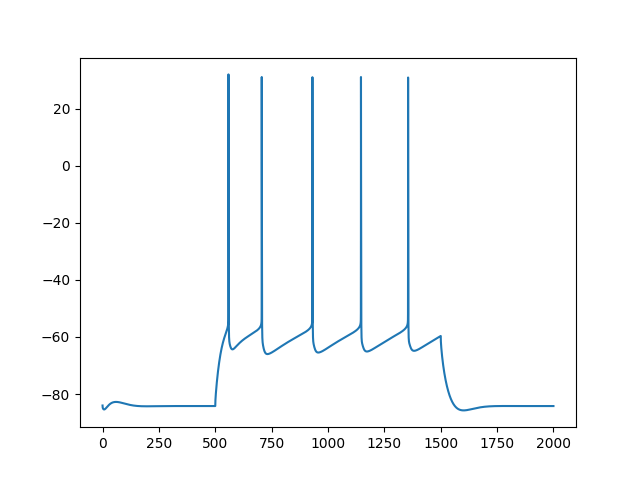

In [54]:
plt.figure()
plt.plot(rec_t, vs[0], label="py version")

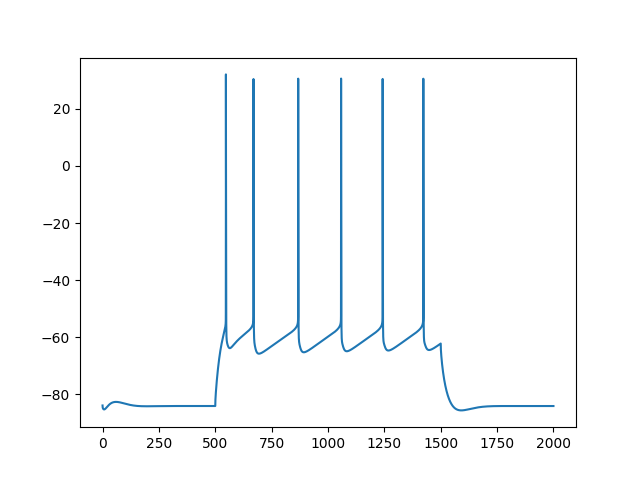

In [55]:
plt.figure()
plt.plot(rec_t, vs[1], label="py version")

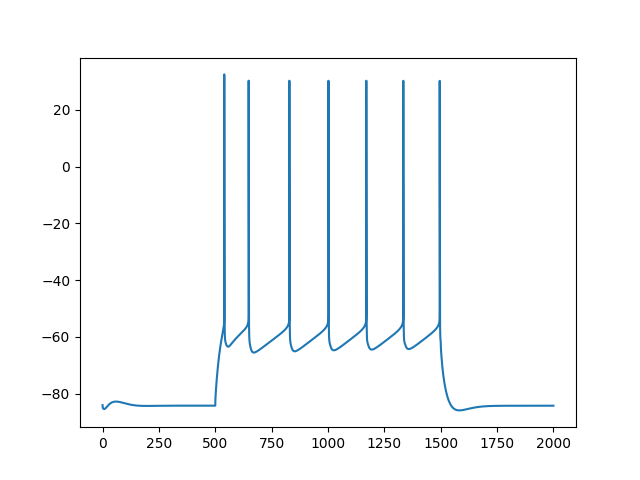

In [56]:
plt.figure()
plt.plot(rec_t, vs[2], label="py version")